# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

torch.manual_seed(42)
np.random.seed(42)

# Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# MNIST Data

Dataset and Dataloader

In [3]:
mnist_dataset = datasets.MNIST(root='./data', download=True, transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(mnist_dataset, [55000, 5000])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [4]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])


# Model Achitecture

In [5]:
class TwoLayerMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear2(self.relu(self.linear1(x)))

model = TwoLayerMLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [6]:
epochs = 50
metrics = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        Y_hat = model(X)
        loss = criterion(Y_hat, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            Y_hat = model(X)
            loss = criterion(Y_hat, Y)
            accuracy = (Y_hat.argmax(dim=1) == Y).float().mean()

    train_loss /= len(train_loader)
    metrics["train_loss"].append(train_loss)

    metrics["val_loss"].append(loss.item())
    metrics["val_acc"].append(accuracy.item())

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {loss.item():.4f}, Val Acc: {accuracy.item():.4f}")

Epoch 1/50, Train Loss: 0.4447, Val Loss: 0.2723, Val Acc: 0.9210
Epoch 2/50, Train Loss: 0.2230, Val Loss: 0.2088, Val Acc: 0.9400
Epoch 3/50, Train Loss: 0.1744, Val Loss: 0.1794, Val Acc: 0.9466
Epoch 4/50, Train Loss: 0.1461, Val Loss: 0.1551, Val Acc: 0.9566
Epoch 5/50, Train Loss: 0.1283, Val Loss: 0.1378, Val Acc: 0.9584
Epoch 6/50, Train Loss: 0.1154, Val Loss: 0.1355, Val Acc: 0.9600
Epoch 7/50, Train Loss: 0.1067, Val Loss: 0.1255, Val Acc: 0.9656
Epoch 8/50, Train Loss: 0.1000, Val Loss: 0.1173, Val Acc: 0.9656
Epoch 9/50, Train Loss: 0.0950, Val Loss: 0.1130, Val Acc: 0.9652
Epoch 10/50, Train Loss: 0.0919, Val Loss: 0.1136, Val Acc: 0.9684
Epoch 11/50, Train Loss: 0.0885, Val Loss: 0.1134, Val Acc: 0.9650
Epoch 12/50, Train Loss: 0.0867, Val Loss: 0.1093, Val Acc: 0.9690
Epoch 13/50, Train Loss: 0.0835, Val Loss: 0.1083, Val Acc: 0.9688
Epoch 14/50, Train Loss: 0.0826, Val Loss: 0.1121, Val Acc: 0.9662
Epoch 15/50, Train Loss: 0.0811, Val Loss: 0.1020, Val Acc: 0.9710
Epoc

# Visualization

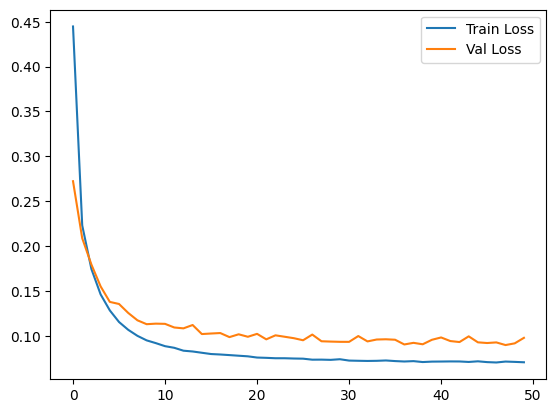

In [10]:
plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["val_loss"], label="Val Loss")
plt.legend()
plt.show()

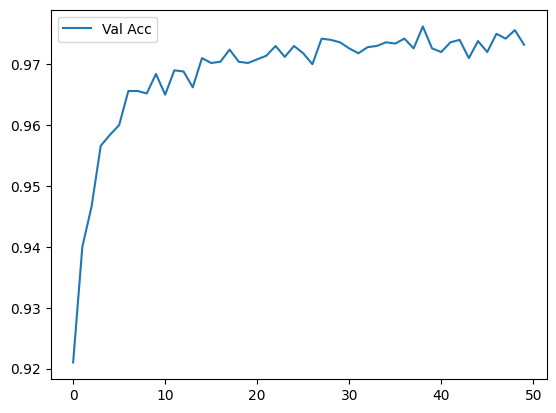

In [11]:
plt.plot(metrics["val_acc"], label="Val Acc")
plt.legend()
plt.show()

# Final Preds

accuracy: tensor(0.9732)
torch.Size([134])
torch.Size([134])


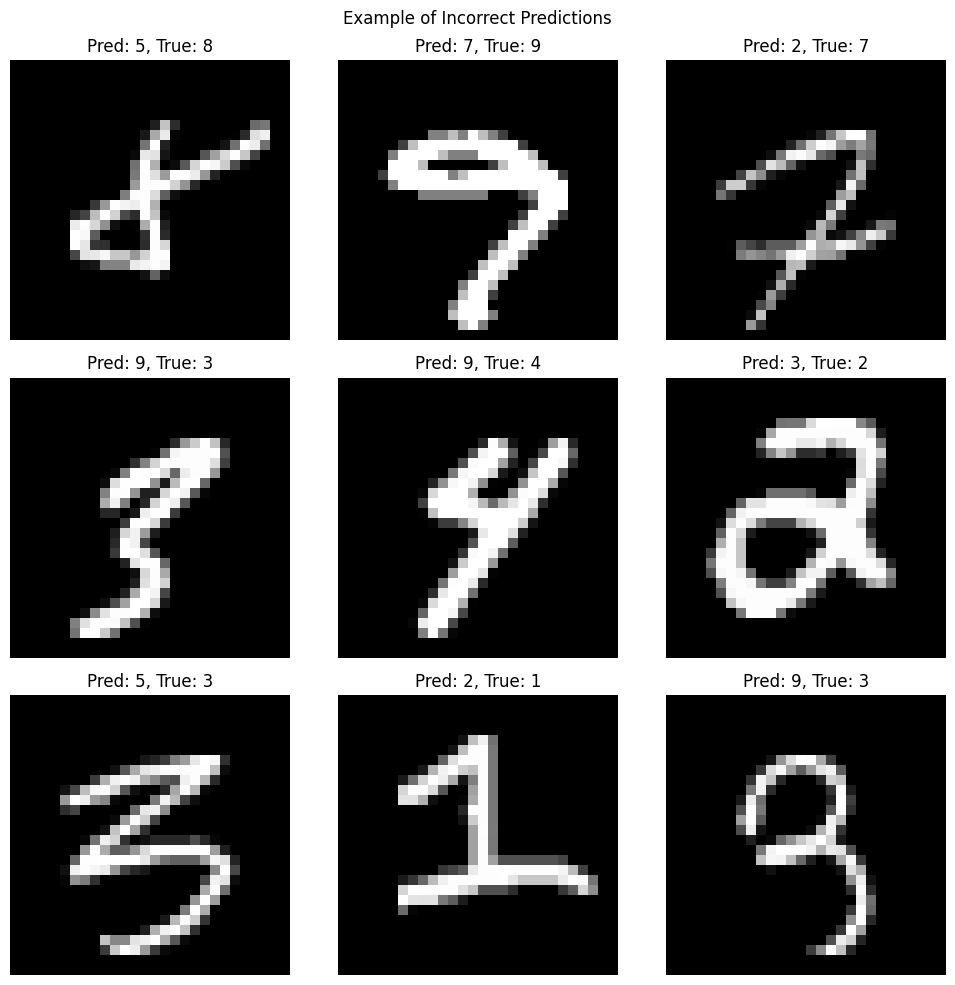

In [41]:
with torch.no_grad():
    model.eval()
    for X, Y in val_loader:
        X, Y = X.to(device), Y.to(device)
        Y_hat = model(X)
        preds = Y_hat.argmax(dim=1)
        break

print("accuracy:", (preds == Y).float().mean())

indices = torch.where(preds != Y)[0]
preds_incorrect = preds[indices]
Y_incorrect = Y[indices]

print(preds_incorrect.shape)
print(Y_incorrect.shape)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    ax = axes[i // 3, i % 3]
    ax.imshow(X[indices[i]].cpu().numpy().reshape(28, 28), cmap="gray")
    ax.set_title(f"Pred: {preds_incorrect[i]}, True: {Y_incorrect[i]}", fontsize=12)
    ax.axis("off")

fig.suptitle("Example of Incorrect Predictions")
plt.tight_layout()
plt.show()

In [42]:
torch.save(model.state_dict(), "mnist_model.pth")